In [1]:
import os
import sys
import json
import pickle
import gzip
import h5py
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
from importlib import reload
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset


import matplotlib.pyplot as plt
new_rc_params = {'text.usetex': False, 'svg.fonttype': 'none' }
plt.rcParams.update(new_rc_params)
FONTSIZE = 8
font_rc_params = {"font.size": FONTSIZE, "axes.titlesize": FONTSIZE, "axes.labelsize": FONTSIZE, "xtick.labelsize": FONTSIZE, "ytick.labelsize": FONTSIZE, "legend.fontsize": FONTSIZE, "figure.titlesize": FONTSIZE}
plt.rcParams.update(font_rc_params)
LINEWIDTH = 1
AXISWIDTH = 1
linewidth_rc_params = {"lines.linewidth": LINEWIDTH, "axes.linewidth": AXISWIDTH, "xtick.major.width": AXISWIDTH, "ytick.major.width": AXISWIDTH, "xtick.minor.width": AXISWIDTH, "ytick.minor.width": AXISWIDTH, "xtick.major.size": AXISWIDTH, "ytick.major.size": AXISWIDTH, "xtick.minor.size": AXISWIDTH, "ytick.minor.size": AXISWIDTH}
# set matplot axis linewidth
plt.rcParams.update(linewidth_rc_params)

sys.path.append("../scripts/")
from config import hg19 as HG19_FASTA
from utils import get_reverse_strand, load_fasta, get_figure_size, set_spines
genome = load_fasta(HG19_FASTA)

- load processed genome: /bigdat1/pub/UCSC/hg19/bigZips/hg19.fa.cache.pkl


In [2]:
def get_aligned_attention(attention, centers, flanking: int=100):
    """
    attention: [batch, head, seq_len]
    """
    pad = np.full(shape=(attention.shape[1], flanking), fill_value=np.nan, dtype=np.float16)
    aligned_attention = [list() for _ in range(attention.shape[1])]
    for i in tqdm(range(attention.shape[0])):
        c = centers[i] + flanking
        att = np.concatenate((pad, attention[i], pad), axis=1)
        for h in range(attention.shape[1]):
            aligned_attention[h].append(att[h, c-flanking:c+flanking+1])
    return np.stack(aligned_attention, axis=0)

In [3]:
p_att, q_att, pos1, pos2, type1, type2, dist = dict(), dict(), dict(), dict(), dict(), dict(), dict()
for name in ["acceptor_pair", "donor_pair", "exonic_pair", "intronic_pair", "unpair", "random_pair"]:
    d = pickle.load(open(f"./output/hg19.{name}.1000_per_group.att.pkl", 'rb'))
    print(name, [x.shape for x in d])
    p_att[name] = d[0].mean(axis=2)
    q_att[name] = d[1].mean(axis=2)
    pos1[name] = d[2]
    pos2[name] = d[3]
    type1[name] = d[4]
    type2[name] = d[5]
    dist[name] = d[6]

acceptor_pair [(6806, 6, 3, 1000), (6806, 6, 3, 1000), (6806,), (6806,), (6806,), (6806,), (6806,)]
donor_pair [(6629, 6, 3, 1000), (6629, 6, 3, 1000), (6629,), (6629,), (6629,), (6629,), (6629,)]
exonic_pair [(5999, 6, 3, 1000), (5999, 6, 3, 1000), (5999,), (5999,), (5999,), (5999,), (5999,)]
intronic_pair [(6307, 6, 3, 1000), (6307, 6, 3, 1000), (6307,), (6307,), (6307,), (6307,), (6307,)]
unpair [(6392, 6, 3, 1000), (6392, 6, 3, 1000), (6392,), (6392,), (6392,), (6392,), (6392,)]
random_pair [(6925, 6, 3, 1000), (6925, 6, 3, 1000), (6925,), (6925,), (6925,), (6925,), (6925,)]


In [4]:
p_att_for_q, q_att_for_p = dict(), dict()
for name in ["acceptor_pair", "donor_pair", "exonic_pair", "intronic_pair", "unpair", "random_pair"]:
    p_att_for_q[name] = get_aligned_attention(p_att[name], pos2[name], flanking=100)
    q_att_for_p[name] = get_aligned_attention(q_att[name], pos1[name], flanking=100)

100%|██████████| 6925/6925 [00:00<00:00, 83894.56it/s]


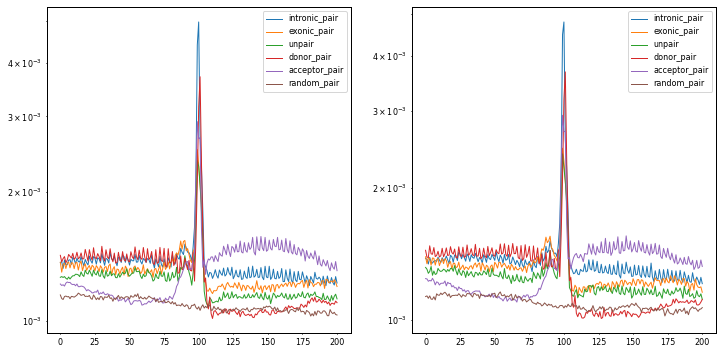

In [5]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
scores = OrderedDict()
scores_norm = OrderedDict()
for name in ["intronic_pair", "exonic_pair", "unpair", "donor_pair", "acceptor_pair", "random_pair"]:
    scores[name] = (p_att_for_q[name].mean(axis=0) + q_att_for_p[name].mean(axis=0))[:, 100-1:100+2].max(axis=1)/2
    scores_norm[name] = scores[name] / ((p_att_for_q[name].mean(axis=0) + q_att_for_p[name].mean(axis=0))[:, 100-10:100+11].max(axis=1)/2)
    scores_norm[name] = np.log10(scores_norm[name])
    # print(scores[name].shape)
    axs[0].plot(np.nanmedian(p_att_for_q[name].mean(axis=0), axis=0), label=name)
    axs[1].plot(np.nanmedian(q_att_for_p[name].mean(axis=0), axis=0), label=name)
axs[0].set_yscale("log")
axs[0].legend()
axs[1].set_yscale("log")
axs[1].legend()
# plt.savefig("./tmp.attention.jpg", dpi=600)

intronic_pair	1.567e-02
exonic_pair	4.894e-03
unpair	6.565e-03
donor_pair	5.795e-03
acceptor_pair	5.623e-03
random_pair	1.806e-03


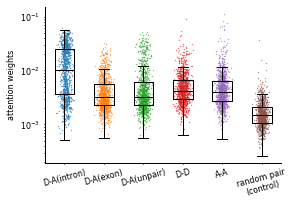

In [6]:
from biock.plot._plot import boxplot_with_scatter
fig = plt.figure(figsize=get_figure_size(0.5, 0.35))
ax = plt.subplot()
# _ = ax.boxplot(scores.values(), positions=xticks, sym='', medianprops=dict(color='black'))
xticks = np.arange(len(scores))
print('\n'.join(["{}\t{:.3e}".format(k, np.mean(v)) for k, v in scores.items()]))
boxplot_with_scatter(
    list(scores.values()), 
    # list(scores_norm.values()), 
    positions=xticks, 
    ax=ax, 
    scatter_kwargs=dict(marker='.', alpha=0.8), max_sample=1000, size=0.5, medianprops=dict(color='black'))
xticklabels = list(scores.keys())
xticklabels = ["D-A(intron)", "D-A(exon)", "D-A(unpair)", "D-D", "A-A", "random pair\n(control)"]
# _ = ax.boxplot(scores.values(), positions=xticks, sym='', medianprops=dict(color='black'))
_ = ax.set_xticks(xticks, xticklabels, rotation=15)
ax.set_yscale("log")
set_spines(ax)
ax.set_ylabel("attention weights")
plt.tight_layout()
# plt.savefig("./Figure_4A.jpg", dpi=600)
# plt.savefig("../figures/attention_pair_by_groups.jpg", dpi=600)
# plt.savefig("../figures/attention_pair_by_groups.svg")

In [7]:
p_att, q_att, p_pos, q_pos, type1, type2, dist = pickle.load(open("./gencode.v41lift37.MANE.intron.for_attention.att.v2.pkl", 'rb'))
forward = p_pos < q_pos

In [8]:
d_att = np.concatenate((p_att[forward], q_att[~forward]))
a_att = np.concatenate((q_att[forward], p_att[~forward]))
d_pos = np.concatenate((p_pos[forward], q_pos[~forward]))
a_pos = np.concatenate((q_pos[forward], p_pos[~forward]))
del p_att, q_att, p_pos, q_pos

In [9]:
def get_aligned_attention_by_layer(attention, centers, flanking: int=100):
    """
    attention: [batch, layer, seq_len]
    """
    pad = np.full(shape=(attention.shape[1], flanking), fill_value=np.nan, dtype=np.float16)
    aligned_attention = [list() for _ in range(attention.shape[1])]
    for i in tqdm(range(attention.shape[0])):
        c = centers[i] + flanking
        att = np.concatenate((pad, attention[i], pad), axis=1)
        for h in range(attention.shape[1]):
            aligned_attention[h].append(att[h, c-flanking:c+flanking+1])
            # aligned_attention[h].append(att[h, c])
    return np.stack(aligned_attention, axis=0)

In [10]:
donor_att_for_acceptor = get_aligned_attention_by_layer(d_att[:, :, 1], a_pos, flanking=100)
print(donor_att_for_acceptor.shape)
acceptor_att_for_donor = get_aligned_attention_by_layer(a_att[:, :, 1], d_pos, flanking=100)
print(acceptor_att_for_donor.shape)

100%|██████████| 48109/48109 [00:01<00:00, 46492.66it/s]


(6, 48109, 201)


100%|██████████| 48109/48109 [00:00<00:00, 84800.16it/s]


(6, 48109, 201)


In [11]:
donor_att_for_acceptor.shape

(6, 48109, 201)

In [12]:
donor_att_for_acceptor[3][:, 99].mean(), \
acceptor_att_for_donor[3][:, 99].mean()

(0.1237, 0.01164)

In [13]:
np.nanmean(donor_att_for_acceptor[3].astype(np.float32))

0.0027549188

In [14]:
for h in range(0, 6):
    print("{}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}".format(h + 1, \
        np.mean(donor_att_for_acceptor[h][:, 99:102].mean(axis=1)), np.nanmean(donor_att_for_acceptor[h].astype(np.float32)), np.mean(donor_att_for_acceptor[h][:, 99:102].mean(axis=1)) / np.nanmean(donor_att_for_acceptor[h].astype(np.float32)), \
        np.mean(acceptor_att_for_donor[h][:, 99:102].mean(axis=1)), np.nanmean(acceptor_att_for_donor[h].astype(np.float32)), np.mean(acceptor_att_for_donor[h][:, 99:102].mean(axis=1)) / np.nanmean(acceptor_att_for_donor[h].astype(np.float32))))

    # print("{}\t{:.4f}\t{:.4f}".format(h + 1, \
    #     np.median(donor_att_for_acceptor[h][:, 99:102].mean(axis=1)) / np.nanmedian(donor_att_for_acceptor[h].astype(np.float32)),\
    #     np.median(acceptor_att_for_donor[h][:, 99:102].mean(axis=1)) / np.nanmedian(acceptor_att_for_donor[h].astype(np.float32))))


1	0.0022	0.0032	0.6828	0.0028	0.0034	0.8328
2	0.0014	0.0026	0.5433	0.0017	0.0025	0.6631
3	0.0051	0.0028	1.8636	0.0035	0.0028	1.2215
4	0.0443	0.0028	16.0956	0.1067	0.0046	23.3414
5	0.0043	0.0025	1.6813	0.0075	0.0027	2.7160
6	0.0020	0.0028	0.7277	0.0033	0.0032	1.0173


In [15]:
def make_plot_ticks(seq_len, step=10):
    assert seq_len % 2 == 1
    center = seq_len // 2
    inds = []

    for k in range(0, seq_len//2 + 1, step):
        inds.append(center+k)
        if k > 0:
            inds.append(center-k)
    inds = np.asarray(sorted(inds))
    dist = np.abs(inds - seq_len//2)
    return inds, dist

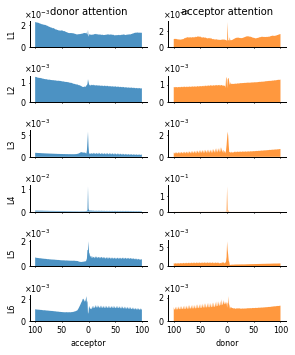

In [16]:
from matplotlib.ticker import StrMethodFormatter, FormatStrFormatter
fig, axs = plt.subplots(ncols=2, nrows=6, figsize=get_figure_size(0.5, 0.6), sharex=True, sharey=False)
alpha = 0.8
for h in range(6):
    ax = axs[h, 0]
    if h == 0:
        ax.set_title("donor attention", fontsize=10)
    elif h == 5:
        ax.set_xlabel("acceptor")

    plot_data = np.nanmedian(donor_att_for_acceptor[h], axis=0)
    magnitude = int(-np.floor(np.log10(plot_data.max())))
    ax.fill_between(x=np.arange(len(plot_data)), y1=0, y2=plot_data * 10**magnitude, alpha=alpha, color="tab:blue", edgecolor=None)
    # ax.plot(np.arange(len(plot_data)), plot_data * 10**magnitude, color="tab:blue")
    yticks = ax.get_yticks()
    # if len(yticks) > 1:
    #     ax.set_yticks([0, yticks[-1]])
    ax.set_ylim(0, ax.get_ylim()[1])

    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    # ax.set_ylim(0, 0.1)
    set_spines(ax)
    ax.set_ylabel("L{}".format(h+1))
    y = ax.get_ylim()[1]
    ax.text(-20, y*1.1, s=r"$\times 10^{-%d}$"%magnitude)
    # ax.set_yscale("log")
inds, dist = make_plot_ticks(201, 50)
ax.set_xticks(inds)
ax.set_xticklabels(dist)

for h in range(6):
    ax = axs[h, 1]
    if h == 0:
        ax.set_title("acceptor attention", fontsize=10)
    elif h == 5:
        ax.set_xlabel("donor")
    plot_data = np.nanmedian(acceptor_att_for_donor[h], axis=0)
    magnitude = int(-np.floor(np.log10(plot_data.max())))
    ax.fill_between(x=np.arange(len(plot_data)), y1=0, y2=plot_data * 10**magnitude, alpha=alpha, color="tab:orange", edgecolor=None)
    # ax.plot(np.arange(len(plot_data)), plot_data * 10**magnitude, color="tab:orange")
    yticks = ax.get_yticks()
    # if len(yticks) > 1:
    #     ax.set_yticks([0, yticks[-1]])
    ax.set_ylim(0, ax.get_ylim()[1])

    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    # ax.set_ylim(0, 0.1)
    set_spines(ax)
    # ax.set_ylabel("L{}".format(h+1))
    y = ax.get_ylim()[1]
    ax.text(-20, y*1.1, s=r"$\times 10^{-%d}$"%magnitude)

plt.tight_layout()
plt.savefig("intron_donor-acceptor.all-layers.svg")
# plt.savefig("../figures/donor-acceptor.all-layers.pdf")
plt.show()
plt.close()